In [2]:
from resources import *

/Users/pataan/Dropbox/DPhil/DAPPER


In this section we're going to code an EnKF implementation using numpy.
The EnKF algorithm is given by eqns (2.12) - (2.17) of the [theoretical companion](./DA_intro.pdf#page=11). It is also exlained below.

In [3]:
EnKF_animation

We will make use of `estimate_mean_and_cov` and `estimate_cross_cov` from the previous section. Paste them in below.

In [3]:
# def estimate_mean_and_cov ...
def estimate_mean_and_cov(E):
    m, N = E.shape
    x_bar = np.sum(E,axis=1,keepdims=True)/N
    A     = E - x_bar
    P_bar = A @ A.T / (N-1)   
    return x_bar, P_bar

def estimate_cross_cov(E1,E2):
    N = E1.shape[1]
    assert N==E2.shape[1]
    A1 = E1 - np.mean(E1,axis=1,keepdims=True)
    A2 = E2 - np.mean(E2,axis=1,keepdims=True)
    CC = A1 @ A2.T / (N-1)
    return CC

## Experimental setup

Before making the EnKF, we'll also set up an experiment to test it with. To that end, we'll use the Lorenz-63 model, from [T4](T4 - Dynamical systems, chaos, Lorenz.ipynb). The coupled ODEs are recalled here, but with some of the paremeters fixed.

In [4]:
m = 3 # ndim

def dxdt(x):
    sig  = 10.0
    rho  = 28.0
    beta = 8.0/3
    x,y,z = x
    d     = np.zeros(3)
    d[0]  = sig*(y - x)
    d[1]  = rho*x - y - x*z
    d[2]  = x*y - beta*z
    return d

Next, we make a "black box" forecast model form $\mathbf{x}(t+dt) = f(\mathbf{x}(t),t,dt)$ out of $\frac{d \mathbf{x}}{dt}$. We'll make use of the "4th order Runge-Kutta" integrator `rk4`.

In [5]:
def f(E, t0, dt):
    
    def step(x0):
        return rk4(lambda t,x: dxdt(x), x0, t0, dt)
    
    if E.ndim == 1:
        # Truth (single state vector) case
        E = step(E)
    else:
        # Ensemble case
        for n in range(E.shape[1]):
            E[:,n] = step(E[:,n])
    
    return E


Q_chol = zeros((m,m))
Q      = Q_chol @ Q_chol.T

Notice the loop over each ensemble member. For better performance, this should be vectorized, if possible. Or, if the forecast model is computationally demanding (as is typically the case in real applications), the loop should be parallellized: i.e. the forecast simulations should be distributed to seperate computers.

The following are the time settings that we will use

In [6]:
dt    = 0.01           # integrational time step
dkObs = 25             # number of steps between observations
dtObs = dkObs*dt       # time between observations
KObs  = 60             # total number of observations
K     = dkObs*(KObs+1) # total number of time steps

Initial conditions

In [7]:
mu0     = array([1.509, -1.531, 25.46])
P0_chol = eye(3)
P0      = P0_chol @ P0_chol.T

Observation model settings

In [23]:
p = 3 # ndim obs
def h(E, t):
    if E.ndim == 1: return E[:p]
    else:           return E[:p,:]

R_chol = sqrt(2)*eye(p)
R      = R_chol @ R_chol.T

Generate synthetic truth (`xx`) and observations (`yy`)

In [24]:
# Init
xx    = zeros((K+1   ,m))
yy    = zeros((KObs+1,p))
xx[0] = mu0 + P0_chol @ randn(m)

# Loop
for k in range(1,K+1):
    xx[k]  = f(xx[k-1],(k-1)*dt,dt)
    xx[k] += Q_chol @ randn(m)
    if not k%dkObs:
        kObs = k//dkObs-1
        yy[kObs] = h(xx[k],nan) + R_chol @ randn(p)

## EnKF

**Exc:** Complete the code below

In [25]:
mu = zeros((K+1,m))

# Useful linear algebra: compute B/A
def divide_1st_by_2nd(B,A):
    return nla.solve(A.T,B.T).T

def my_EnKF(N):
    # Init ensemble
    ...
    for k in range(1,K+1):
        # Forecast
        t   = k*dt
        # use model
        E   = ...
        # add noise
        E  += ...
        if not k%dkObs:
            # Analysis
            y        = yy[k//dkObs-1] # current observation
            hE       = h(E,t)         # obsrved ensemble
            # Compute ensemble moments
            BH       = ...
            HBH      = ...
            # Compute Kalman Gain 
            KG       = ...
            # Generate perturbations
            Perturb  = ...
            # Update ensemble with KG
            E       += 
        # Save statistics
        mu[k] = mean(E,axis=1)

SyntaxError: invalid syntax (<ipython-input-25-069ce7d57ced>, line 29)

Notice that we only store some stats (`mu`). This is because in large systems, keeping the entire ensemble in memory is probably too much.

In [26]:
answers['EnKF v1'] = ['MD',r'''
    def my_EnKF(N):
        E = mu0[:,None] + P0_chol @ randn((m,N))
        for k in range(1,K+1):
            # Forecast
            t   = k*dt
            E   = f(E,t-dt,dt)
            E  += Q_chol @ randn((m,N))
            if not k%dkObs:
                # Analysis
                y        = yy[k//dkObs-1] # current obs
                hE       = h(E,t)
                PH       = estimate_cross_cov(E,hE)
                HPH      = estimate_mean_and_cov(hE)[1]
                Perturb  = R_chol @ randn((p,N))
                KG       = divide_1st_by_2nd(PH, HPH+R)
                E       += KG @ (y[:,None] - Perturb - hE)
            mu[k] = mean(E,axis=1)
''']
show_answer('EnKF v1')

In [27]:
mu = zeros((K+1,m))

# B/A
def divide_1st_by_2nd(B,A):
    return nla.solve(A.T,B.T).T

def my_EnKF(N):
    E = mu0[:,None] + P0_chol @ randn((m,N))
    for k in range(1,K+1):
        # Forecast
        t   = k*dt
        E   = f(E,t-dt,dt)
        E  += Q_chol @ randn((m,N))
        if not k%dkObs:
            # Analysis
            y        = yy[k//dkObs-1] # current obs
            hE       = h(E,t)
            PH       = estimate_cross_cov(E,hE)
            HPH      = estimate_mean_and_cov(hE)[1]
            Perturb  = R_chol @ randn((p,N))
            KG       = divide_1st_by_2nd(PH, HPH+R)
            E       += KG @ (y[:,None] - Perturb - hE)
        mu[k] = mean(E,axis=1)

Now let's try out its capabilities

<IPython.core.display.Javascript object>


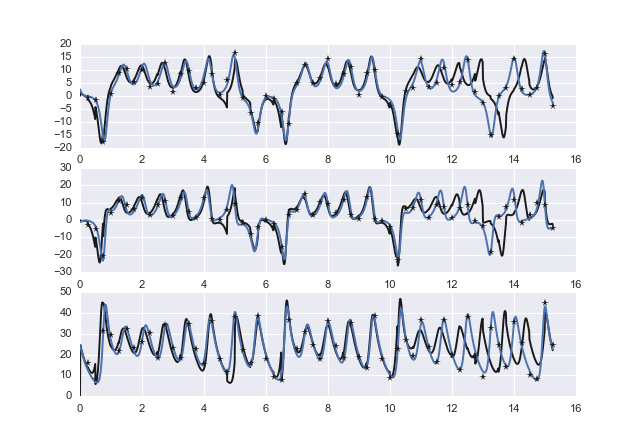

In [30]:
# Run assimilation
my_EnKF(5)

# Plot results
plt.subplot(311)
plt.plot(dt   *arange(K+1)     ,mu[:,0],'k')
plt.plot(dt   *arange(K+1)     ,xx[:,0],'b')
plt.plot(dtObs*arange(1,KObs+2),yy[:,0],'k*')
plt.subplot(312)
plt.plot(dt   *arange(K+1)     ,mu[:,1],'k')
plt.plot(dt   *arange(K+1)     ,xx[:,1],'b')
plt.plot(dtObs*arange(1,KObs+2),yy[:,1],'k*')
plt.subplot(313)
plt.plot(dt   *arange(K+1)     ,mu[:,2],'k')
plt.plot(dt   *arange(K+1)     ,xx[:,2],'b')
plt.plot(dtObs*arange(1,KObs+2),yy[:,2],'k*')

**Exc:** The visuals of the plots are nice. But it would be good to have a summary statistic of the accuracy performance of the filter. Make a function `average_rmse(xx,mu)` that computes $ \frac{1}{K+1} \sum_{k=0}^K \sqrt{\frac{1}{m} \| \overline{\mathbf{x}}_k - \mathbf{x}_k \|_2^2} \, .$

In [16]:
def average_rmse(xx,mu):
    ### INSERT ANSWER ###
    rmses = sqrt(np.mean((xx-mu)**2, axis=1))
    return np.mean(rmses)

# Test
average_rmse(xx,mu)

1.4135842467771345

In [17]:
answers['rmse'] = ['MD',r'''
    rmses = sqrt(np.mean((xx-mu)**2, axis=1))
    return np.mean(rmses)
''']
show_answer('rmse')

**Exc:**
 * (a). Repeat the above expriment, but now observing only the first (0th) component of the state. 

In [18]:
answers['Repeat experiment a'] = ['MD',r'''
 * (a). Set `p=1` above, and execute all cells below again.
''']
show_answer('Repeat experiment a')

 * (b). Put a `seed()` command in the right place so as to be able to recreate exactly the same results from an experiment.

In [19]:
answers['Repeat experiment b'] = ['MD',r'''
 * (b). Insert `seed(i)` for some number `i` above the call to the EnKF or above the generation of the synthetic truth and obs.
''']
show_answer('Repeat experiment b')

 * (c). Use $N=5$, and repeat the experiments. This is quite a small ensemble size, and quite often it will yield divergence: the EnKF "definitely loses track" of the truth, typically because of strong nonlinearity in the forecast models, and underestimation (by $\overline{\mathbf{P}})$ of the actual errors. Repeat the experiment with different seeds until you observe in the plots that divergence has happened.
 * (d). Implement "multiplicative inflation" to remedy the situation; this is a factor that should spread the ensemble further apart; a simple version is to inflate the perturbations. Implement it, and tune its value to try to avoid divergence.

In [50]:
answers['Repeat experiment cd'] = ['MD',r'''
 * (c). Void.
 * (d). Use: `Perturb  = D_infl * R_chol @ randn((p,N))` in the EnKF algorithm.
''']
show_answer('Repeat experiment cd')

### Next: [Benchmarking with DAPPER](T7 - Benchmarking with DAPPER.ipynb)